In [1]:
 !pip install chromadb --quiet

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from sentence_transformers import SentenceTransformer

model_id = "all-MiniLM-L6-v2"
model = SentenceTransformer("all-MiniLM-L6-v2").to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Data/ Vector Store

In [4]:
physics = [
    "Albert Einstein formulated the theory of relativity in the early 20th century.",
    "Newton's laws of motion revolutionized our understanding of physics in the 17th century.",
    "Quantum mechanics was developed by physicists like Heisenberg and Schrödinger in the 1920s.",
    "Einstein's famous equation E=mc² demonstrates the equivalence of mass and energy.",
    "The photoelectric effect discovery earned Einstein the Nobel Prize in Physics in 1921.",
    "Niels Bohr proposed the atomic model that explained electron behavior around the nucleus.",
    "Stephen Hawking studied black holes and made groundbreaking contributions to cosmology.",
    "The uncertainty principle states that position and momentum cannot be measured simultaneously.",
    "General relativity predicts that massive objects bend spacetime around them.",
    "Marie Curie conducted pioneering research on radioactivity and discovered polonium and radium.",
    "The double-slit experiment demonstrates the wave-particle duality of light and matter.",
]

biology = [
    "Charles Darwin published his theory of evolution by natural selection in 1859.",
    "DNA contains the genetic instructions for all living organisms on Earth.",
    "Gregor Mendel discovered the fundamental laws of inheritance through pea plant experiments.",
    "The cell theory states that all living things are composed of one or more cells.",
    "Photosynthesis allows plants to convert sunlight into chemical energy for growth.",
    "Watson and Crick determined the double helix structure of DNA in 1953.",
    "Mitosis is the process by which cells divide to create identical daughter cells.",
    "The human genome contains approximately 3 billion DNA base pairs across 23 chromosomes.",
    "Evolution explains the diversity of life through gradual changes over millions of years.",
    "Enzymes are biological catalysts that speed up chemical reactions in living organisms.",
]

history = [
    "The Neolithic Revolution occurred around 10,000–8,000 BCE in the Fertile Crescent.",
    "Cuneiform writing emerged in ancient Mesopotamia by the late 4th millennium BCE.",
    "Classical Athens advanced democratic institutions in the 5th century BCE.",
    "The Roman Empire reached its greatest extent under Trajan around 117 CE.",
    "The Islamic Golden Age spanned roughly the 8th to 13th centuries.",
    "The Mongol Empire unified vast parts of Eurasia in the 13th century.",
    "The Renaissance revitalized art, science, and humanism from the 14th to 17th centuries.",
    "The American Revolution (1776) and French Revolution (1789) reshaped politics.",
    "The Industrial Revolution mechanized production in the late 18th and 19th centuries.",
    "World War II ended in 1945, reshaping the international order.",
]

technology = [
    "Movable-type printing emerged in Europe in the mid-15th century.",
    "The steam engine catalyzed industrialization in the 18th century.",
    "Telegraph networks enabled rapid long-distance communication in the 19th century.",
    "Electrification transformed cities and industry in the late 19th century.",
    "Internal combustion engines powered cars and planes in the early 20th century.",
    "The transistor, invented in 1947, enabled modern electronics.",
    "ARPANET launched in 1969 as a precursor to the Internet.",
    "The World Wide Web spread globally in the 1990s.",
    "Genome sequencing advances accelerated biotech in the 2000s.",
    "Machine learning advances expanded AI applications in the 2010s–2020s.",
]

physics = [{"text": d, "label": "Physics"} for d in physics]
biology = [{"text": d, "label": "Biology"} for d in biology]
history = [{"text": d, "label": "History"} for d in history]
technology = [{"text": d, "label": "Technology"} for d in technology]

documents = physics + biology + history + technology

In [5]:
import chromadb

collection_name = "xai"
client = chromadb.Client()
metric = "l2"
collection = client.get_or_create_collection(
    name=collection_name,
    configuration={
        "hnsw": {
            "space": metric,
            "ef_construction": 200
        }
    }
)

In [6]:
doc_embeddings = model.encode([d["text"] for d in documents]).tolist()

documents = [{"vector": v} | d for d, v in zip(documents, doc_embeddings)]

collection.add(
    ids=[str(i) for i in range(len(doc_embeddings))],
    documents=[d["text"] for d in documents],
    embeddings=doc_embeddings,
    metadatas=[{"label": d["label"]} for d in documents]
)

In [7]:
query = "famous physicists and their contributions"

query_embedding = model.encode(query).tolist()
res = collection.query(query_embedding, n_results=10, include=["embeddings", "documents", "distances", "metadatas"])
res

{'ids': [['6', '2', '4', '1', '0', '3', '9', '11', '13', '10']],
 'embeddings': [array([[-4.14007790e-02,  2.16717627e-02, -1.08505844e-03, ...,
          -4.46190611e-02,  2.61495472e-03,  1.40560716e-02],
         [-1.15475925e-02,  1.69467740e-02, -6.23083226e-02, ...,
           1.99484527e-02,  1.69039853e-02,  6.13281801e-02],
         [-9.31872278e-02,  1.00586846e-01, -3.00539024e-02, ...,
          -4.78570946e-02, -6.92624971e-02,  2.25894768e-02],
         ...,
         [-5.07243238e-02,  5.53676449e-02,  1.19442130e-02, ...,
           6.23587705e-02,  3.17521468e-02,  5.55558540e-02],
         [-7.50079751e-02,  4.24699970e-02,  1.42873917e-02, ...,
           1.44666722e-02,  7.30443522e-02, -5.70261254e-05],
         [-7.11106881e-02, -3.79753858e-02,  6.27442170e-03, ...,
           2.14042850e-02,  4.78801876e-03,  2.19497830e-02]])],
 'documents': [['Stephen Hawking studied black holes and made groundbreaking contributions to cosmology.',
   'Quantum mechanics was dev

In [8]:
def unpack_results(results: dict) -> list[dict]:
    combined = list()
    combined = [{"document": doc, "score": score, "label": meta["label"], "vector": vec} for doc, score, meta, vec in zip(results["documents"][0], results["distances"][0], results["metadatas"][0], results["embeddings"][0])]
    if metric == "cosine" or metric == "ip":
        # Highest score (similarity) on top
        return sorted(combined, key=lambda x: x["score"], reverse=True)
    else:
        # Lowest score (distance) on top
        return sorted(combined, key=lambda x: x["score"], reverse=False)

# Direct Token Importance (Between Query and Documents)

In [9]:
import numpy as np
from sentence_transformers import util

In [10]:
def mean_pooling(token_embeddings, attention_mask):
    mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
    return (token_embeddings * mask_expanded).sum(0) / mask_expanded.sum(0)

### TODO: Start

In [ ]:
# TODO

def token_contribution(tokens: list[str], full_similarity: float, attention_mask: torch.Tensor, token_embeddings: torch.Tensor, comparison_vector: np.ndarray) -> dict[str, float]:
    contributions = dict()

    for i, tok in enumerate(tokens):
        if tok in list(model.tokenizer.special_tokens_map.values()):
            continue

        mask_new = attention_mask.clone()
        mask_new[i] = 0  # Mask Token

        emb_sub = mean_pooling(token_embeddings, mask_new) # create single vector
        sim_sub = util.cos_sim(emb_sub, comparison_vector).item() # masked similarity
        contributions[tok] = sim_sub - full_similarity
    return contributions

In [ ]:
# TODO

def token_importance(query, documents) -> list[dict[str, dict[str, float]]]:
    # Full Embeddings
    query_embedding = model.encode(query)
    document_embeddings = model.encode(documents)

    # Full Query to Documents Embeddings
    full_similarities = util.cos_sim(query_embedding, document_embeddings).tolist()[0]

    # Encoded Query and Documents (input_ids + attention_masks)
    encoded_query = model.tokenize([query])
    encoded_documents = model.tokenize(documents)

    # Attention Masks
    query_attenion_mask = encoded_query["attention_mask"][0]
    document_attention_masks = encoded_documents["attention_mask"]

    # Tokens (not ids)
    query_tokens = model.tokenizer.convert_ids_to_tokens(encoded_query["input_ids"][0])
    documents_tokens = [model.tokenizer.convert_ids_to_tokens(ids) for ids in encoded_documents["input_ids"]]

    # Token Embeddings (Each Token corresponds to a Vector)
    query_token_embeddings = model.encode(query, output_value="token_embeddings", convert_to_tensor=True).squeeze(0).cpu()
    documents_token_embeddings = model.encode(documents, output_value="token_embeddings", convert_to_tensor=True)

    try:
        assert len(documents_tokens) == len(document_attention_masks) == len(documents_token_embeddings) == len(full_similarities) == len(document_embeddings)
    except:
        print(
            f"""Document Tokens: {len(documents_tokens)}\n
            Document Attention Masks: {len(document_attention_masks)}\n
            Document Embeddings: {len(documents_token_embeddings)}\n
            Full Similarities: {len(full_similarities)}\n
            Document Embeddings: {len(document_embeddings)}"""
        )

    # Contributions
    importance = list()
    for doc_tokens, full_sim, attn_mask, tok_emb, doc_emb in zip(documents_tokens, full_similarities, document_attention_masks, documents_token_embeddings, document_embeddings):
        document_token_contributions = token_contribution(doc_tokens, full_sim, attn_mask, tok_emb, query_embedding)
        query_token_contributions = token_contribution(query_tokens, full_sim, query_attenion_mask, query_token_embeddings, doc_emb)
        importance.append(
            {
                "document_contributions": document_token_contributions,
                "query_contributions": query_token_contributions,
            }
        )

    return importance

### TODO: END

In [11]:
def token_importance(query, documents) -> list[dict[str, dict[str, float]]]:
    embedded_query = model.encode(query) # query embedding
    doc_embeds = model.encode(documents) # document embeddings
    full_similarities = util.cos_sim(embedded_query, doc_embeds).tolist()[0] # query to document similarities


    # pre calculate query properties
    encoded_query = model.tokenize([query])
    query_attention_mask = torch.tensor(encoded_query["attention_mask"])[0]
    query_tokens = model.tokenizer.convert_ids_to_tokens(encoded_query["input_ids"][0])
    query_token_embeddings = model.encode(query, output_value="token_embeddings", convert_to_tensor=True).squeeze(0).cpu()

    token_importance = list()
    # Calculate token importance for each document with respect to the query
    for doc, full_sim in zip(documents, full_similarities):

        # document
        document_contributions = dict()
        encoded_document = model.tokenize([doc]) # token ids + attention mask
        document_attention_mask = torch.tensor(encoded_document["attention_mask"])[0]
        document_tokens = model.tokenizer.convert_ids_to_tokens(encoded_document["input_ids"][0]) # convert ids to tokens
        document_token_embeddings = model.encode(doc, output_value="token_embeddings", convert_to_tensor=True).squeeze(0).cpu()

        for i, tok in enumerate(document_tokens):
            if tok in ["[CLS]", "[SEP]"]:
                continue

            mask_new = document_attention_mask.clone()
            mask_new[i] = 0  # Mask Token

            emb_sub = mean_pooling(document_token_embeddings, mask_new) # create single vector
            sim_sub = util.cos_sim(emb_sub, embedded_query).item() # masked similarity
            document_contributions[tok] = sim_sub - full_sim

        # query
        query_contributions = dict()
        document_embedding = model.encode([doc])
        for i, tok in enumerate(query_tokens):
            if tok in ["[CLS]", "[SEP]"]:
                continue

            mask_new = query_attention_mask.clone()
            mask_new[i] = 0

            emb_sub = mean_pooling(query_token_embeddings, mask_new) # create single vector
            sim_sub = util.cos_sim(emb_sub, document_embedding).item() # masked similarity
            query_contributions[tok] = sim_sub - full_sim




        token_importance.append(
            {
                "document_contributions": document_contributions,
                "query_contributions": query_contributions,
            }
        )


    return token_importance

In [12]:
import matplotlib.pyplot as plt

def create_token_importance_plot(results, sharey=True):
    n = len(results)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n), squeeze=False)

    for i, res in enumerate(results):
        doc_contrib = res["document_contributions"]
        qry_contrib = res["query_contributions"]

        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        # Document
        ax_left.bar(list(doc_contrib.keys()), list(doc_contrib.values()), color="#4c78a8")
        ax_left.axhline(0, color="black", linewidth=0.8)
        ax_left.set_title("Document")
        ax_left.set_ylabel("Similarity difference without Token")
        ax_left.tick_params(axis="x", rotation=45)

        # Query
        ax_right.bar(list(qry_contrib.keys()), list(qry_contrib.values()), color="#f58518")
        ax_right.axhline(0, color="black", linewidth=0.8)
        ax_right.set_title("Query")
        ax_right.tick_params(axis="x", rotation=45)

        if sharey:
            ymin = min(min(doc_contrib.values(), default=0), min(qry_contrib.values(), default=0))
            ymax = max(max(doc_contrib.values(), default=0), max(qry_contrib.values(), default=0))
            pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
            ax_left.set_ylim(ymin - pad, ymax + pad)
            ax_right.set_ylim(ymin - pad, ymax + pad)

    fig.suptitle("Token Contributions", y=0.995)
    fig.tight_layout()
    return fig

/tmp/ipython-input-1228030734.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_attention_mask = torch.tensor(encoded_query["attention_mask"])[0]
/tmp/ipython-input-1228030734.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  document_attention_mask = torch.tensor(encoded_document["attention_mask"])[0]


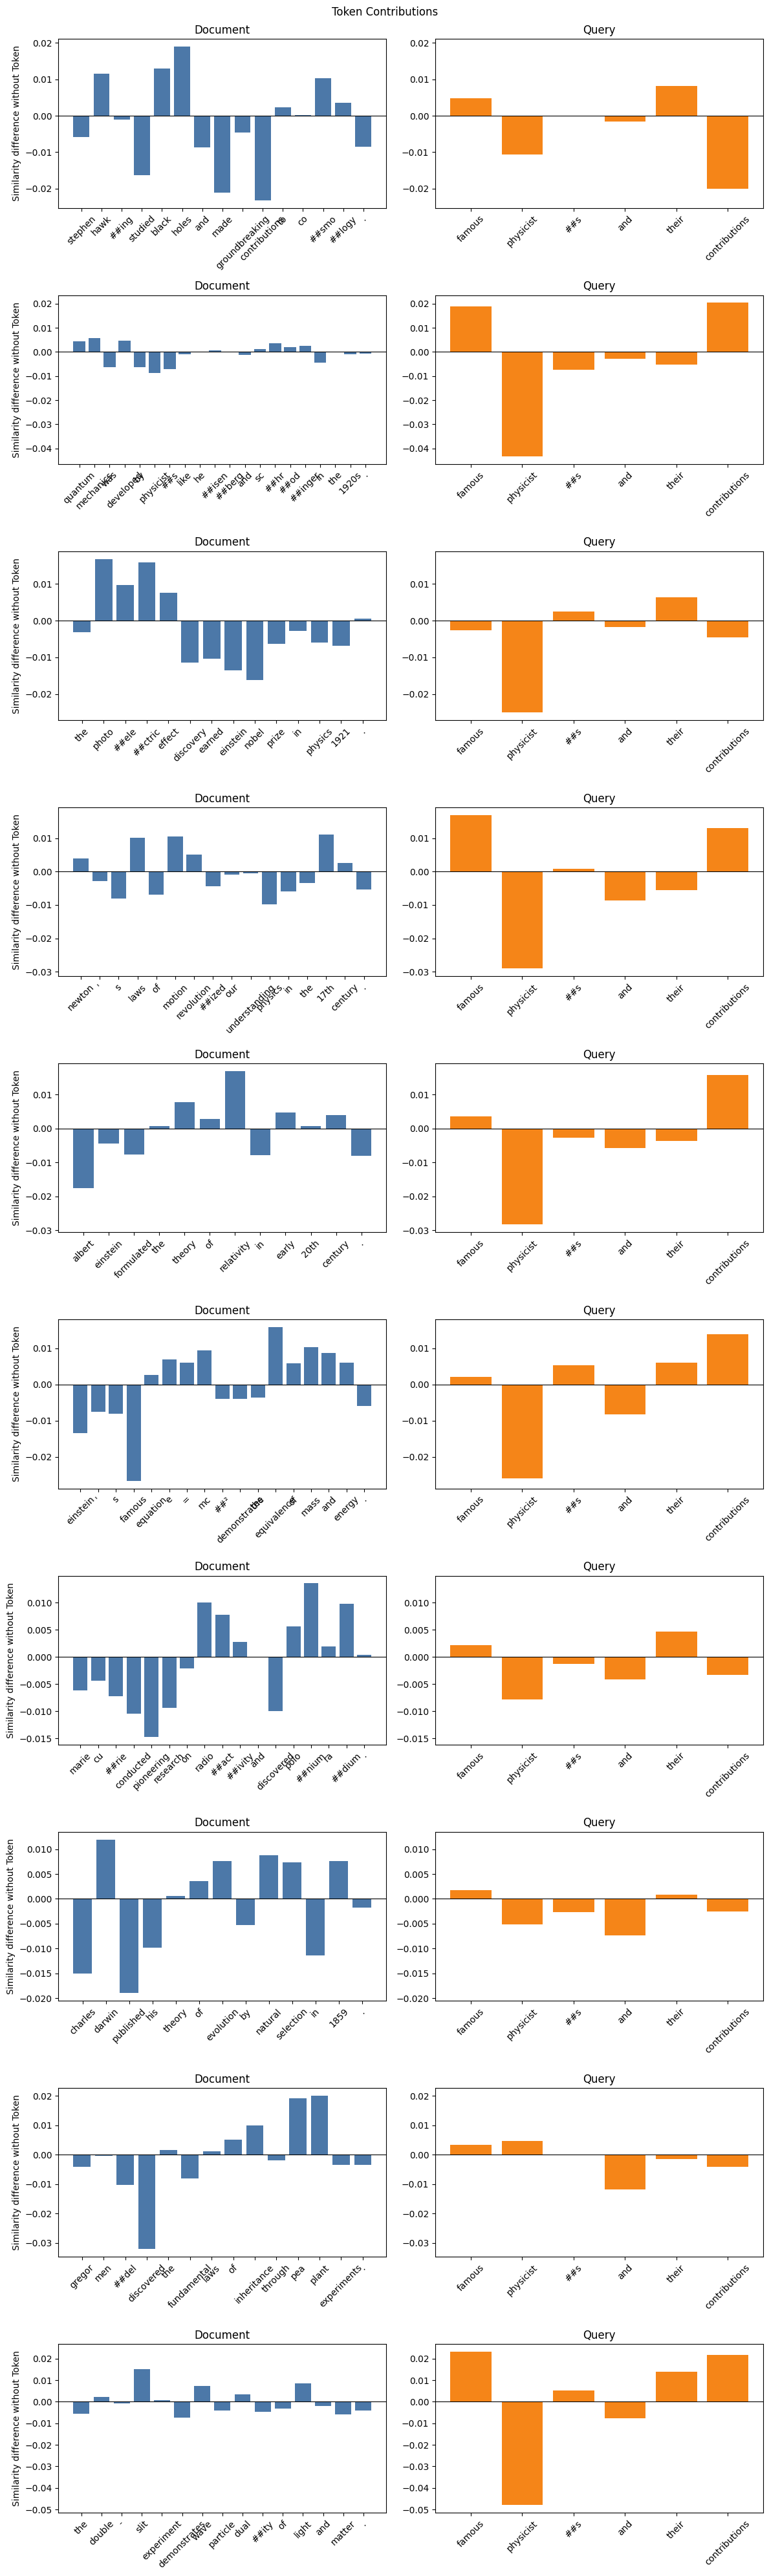

In [13]:
results = unpack_results(res)
importance = token_importance(query, [r["document"] for r in results])

figure = create_token_importance_plot(importance)
figure.show()

# Lime (surrogate model)

# Vector Space

In [14]:
from sklearn.decomposition import PCA

# Labels
phy = model.encode("Physics")
bio = model.encode("Biology")
hist = model.encode("History")
tech = model.encode("Technology")


In [15]:
import umap
import numpy as np

doc_labels = [d["label"] for d in documents]
labels = ["Physics", "Biology", "History", "Technology"]

X = np.vstack([doc_embeddings, phy, bio, hist, tech])
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)
X2 = reducer.fit_transform(X)

doc_X2 = X2[:len(doc_embeddings)]
label_X2 = X2[len(doc_embeddings):]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [16]:
import plotly.graph_objects as go


color_map = {
    "Physics": "#1f77b4",
    "Biology": "#2ca02c",
    "History": "#d62728",
    "Technology": "#9467bd",
}
label_colors = [color_map[lbl] for lbl in labels]
point_colors = [color_map[lbl] for lbl in doc_labels]

hover_text_docs = [
    f"Label: {lbl}<br>Text: {txt}" for lbl, txt in zip(doc_labels, [d["text"] for d in documents])
]

doc_trace = go.Scattergl(
    x=doc_X2[:, 0],
    y=doc_X2[:, 1],
    mode="markers",
    marker=dict(color=point_colors, size=7, line=dict(color="white", width=0.5)),
    text=hover_text_docs,
    hovertemplate="%{text}<extra></extra>",
    name="Documents",
)

label_trace = go.Scattergl(
    x=label_X2[:, 0],
    y=label_X2[:, 1],
    mode="markers+text",
    text=labels,
    textposition="middle center",
    textfont=dict(color=label_colors, size=14, family="Arial Black"),
    marker=dict(color=label_colors, size=12, line=dict(color="black", width=1)),
    hovertemplate="Concept vector: %{text}<extra></extra>",
    name="Concepts",
)

fig = go.Figure(data=[doc_trace, label_trace])
fig.update_layout(
    title=f"UMAP: Document to Conecept - {model_id}",
    xaxis_title="UMAP-1",
    yaxis_title="UMAP-2",
    hovermode="closest",
    template="plotly_white",
    legend_title="Ebenen",
)
fig.write_html("umap_concepts.html", include_plotlyjs="cdn")
fig.show()


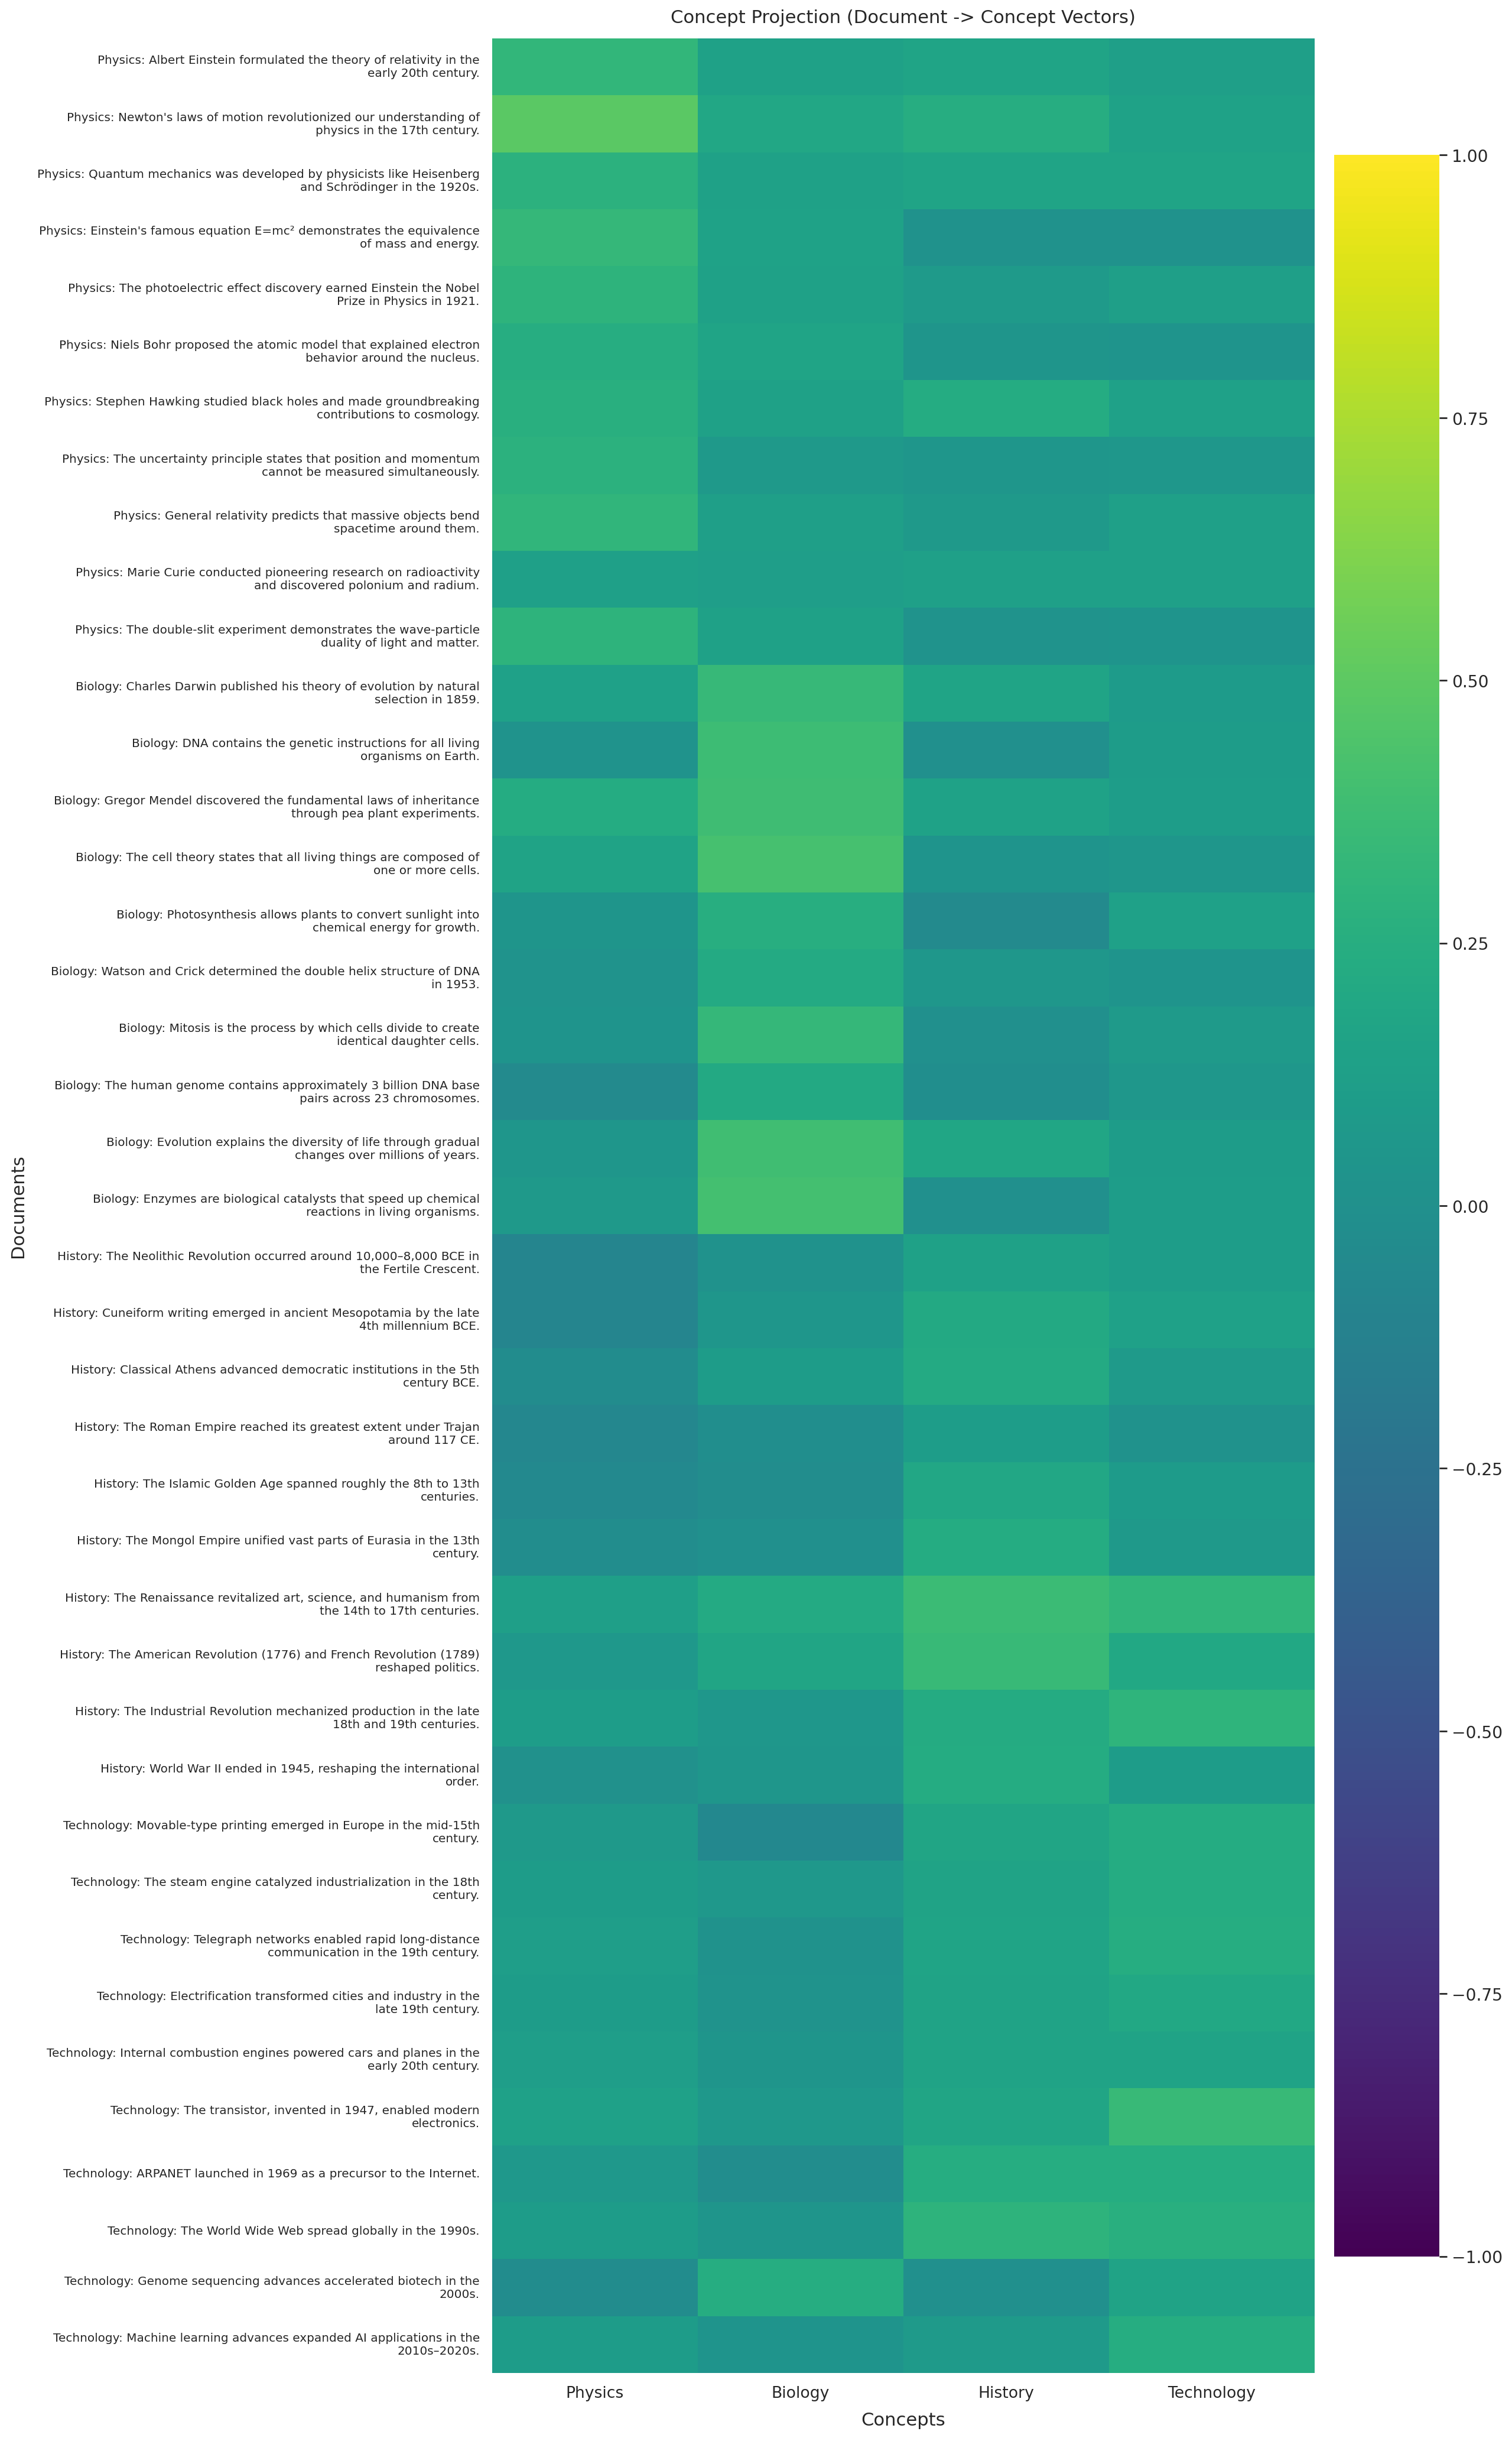

In [18]:
import seaborn as sns
import textwrap


concept_mat = np.vstack([phy, bio, hist, tech])
proj = util.cos_sim(doc_embeddings, concept_mat).detach().cpu().numpy()

ytexts = [textwrap.fill(f"{d['label']}: {d['text']}", width=70) for d in documents]

sns.set(font_scale=1.15)
fig, ax = plt.subplots(figsize=(16, 26), dpi=160)

hm = sns.heatmap(
    proj,
    ax=ax,
    cmap="viridis",
    vmin=-1.0, vmax=1.0,
    xticklabels=labels,
    yticklabels=ytexts,
    annot=False,
    cbar_kws={"shrink": 0.9, "pad": 0.02}
)

ax.set_title("Concept Projection (Document -> Concept Vectors)", pad=12)
ax.set_xlabel("Concepts", labelpad=8)
ax.set_ylabel("Documents", labelpad=8)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=9)

plt.tight_layout()
plt.show()